In [77]:
import pandas as pd

import numpy as np
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.ndimage.morphology import binary_closing
from scipy.optimize import curve_fit
from scipy.misc import imsave
import scipy.io as sio

import cv2
from PIL import ImageFilter
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, label, find_contours
from skimage.restoration import unwrap_phase
from skimage.feature import blob_log, canny
from skimage.exposure import equalize_hist

import random
import os
import fnmatch
import math
import re

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [78]:
#undefined: see https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
CV_CAP_PROP_FRAME_HEIGHT = 4
CV_CAP_PROP_FRAME_WIDTH = 3
CV_CAP_PROP_FRAME_COUNT = 7
CV_CAP_PROP_FPS = 5

In [79]:
source_folders = []

source_folders.append(("data\\heparin\\2018.5.15\\prp1", "2018.5.15", 1800))
source_folders.append(("data\\heparin\\2018.5.15\\prp2", "2018.5.15", 3600))
source_folders.append(("data\\heparin\\2018.5.15\\prp3", "2018.5.15", 7200))
source_folders.append(("data\\heparin\\2018.6.1\\prp1", "2018.6.1", 1800))
source_folders.append(("data\\heparin\\2018.6.1\\prp2", "2018.6.1", 3600))
source_folders.append(("data\\heparin\\2018.6.1\\prp3", "2018.6.1", 7200))
source_folders.append(("data\\heparin\\2018.6.5\\prp1", "2018.6.5", 1800))
source_folders.append(("data\\heparin\\2018.6.5\\prp2", "2018.6.5", 3600))
source_folders.append(("data\\heparin\\2018.6.5\\prp3", "2018.6.5", 7200))
source_folders.append(("data\\heparin\\2018.6.6\\prp1", "2018.6.6", 1800))
source_folders.append(("data\\heparin\\2018.6.6\\prp2", "2018.6.6", 3600))
source_folders.append(("data\\heparin\\2018.6.6\\prp3", "2018.6.6", 7200))

img_path = "data\\heparin"

## Image Conversion

In [80]:
mat_path = "I:\\Honours-Project\\data\\test data\\simulation\\test_hologram_5.mat"

In [81]:
pp_path = "I:\\Honours-Project\\data\\pp.csv"
curve_path = "I:\\Honours-Project\\data\\curve.csv"

In [82]:
npy_path = "panda_hologram.npy"

In [83]:
image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\15.tif"
#image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\fc2_save_2018-05-15-152139-0000.avi_frame75.jpg"
#image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\c1.tif"
#image_path = "I:\\Honours-Project\\data\\test data\\video\\frames\\holo1.avi_frame10.tif"
image_path = "I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\MATLAB_0003.avi_frame0.tif"
image_path = "I:\\Honours-Project\\data\\test data\\simulation\\imagej_test_4.jpg"
folder_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\"

In [84]:
# 0 - Image; 1 - Matlab Matrix; 2 - numpy array

k = 2

if k == 0:
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
elif k == 1:
    mat_contents = sio.loadmat(mat_path)
    gray = mat_contents['hologram']
elif k == 2:
    gray = np.load(npy_path)

In [85]:
cv2.imshow('image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [86]:
np.max(gray)

8.99999974656733

Source for block: https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python

In [87]:
def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

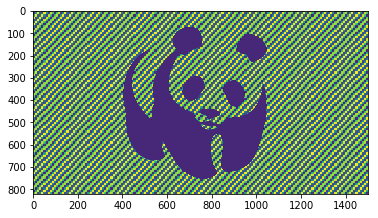

In [88]:
plt.imshow(gray)

In [89]:
class VideoReconstructor():
    popt = None

In [90]:
global_VR = VideoReconstructor()

## Crop out walls

In [91]:
'''
    We assume that the walls are in the left and right most quadrant of the image, and a vertical stripes.
    We make no assumptions about the length of the wall
'''

class VideoReconstructor(VideoReconstructor):
    def crop_border(self,img):

        #source: https://stackoverflow.com/questions/39465812/how-to-crop-zero-edges-of-a-numpy-array

        # argwhere will give you the coordinates of every non-zero point
        true_points = np.argwhere(img)
        # take the smallest points and use them as the top left of your crop
        top_left = true_points.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_points.max(axis=0)

        out = img[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
              top_left[1]:bottom_right[1]+1]  # inclusive

        return out

    def crop_walls(self,img):
        img = self.crop_border(img)

        print(img.shape)

        level = threshold_otsu(img)

        left_quad = int(img.shape[1]/4)
        right_quad = img.shape[1]-left_quad

        img_sum = np.mean(img, axis=0)

        # Calculate a threshold for the wall
        thresh = np.mean(img_sum) - (np.std(img_sum))
        img_sum_mean = np.mean(img_sum)
        img_sum_std = np.std(img_sum)

        left_wall_pos = None
        right_wall_pos = None

        for i in range(left_quad):
            s = img_sum[left_quad-i]

            if s < thresh:
                left_wall_pos = left_quad-i + 30
                break

        for i in range(right_quad):
            s = img_sum[-(right_quad-i)]

            if s < thresh:
                right_wall_pos = img.shape[1] - right_quad+i - 30
                break

        print(np.std(img_sum))
        print(np.mean(img_sum))

        ostu = threshold_otsu(img_sum)

        '''print(left_wall_pos)
        print(right_wall_pos)

        pil_im = Image.fromarray(np.uint8(img[:,left_wall_pos:right_wall_pos]))
        plt.imshow(np.asarray(pil_im))'''

        #plt.bar(np.arange(len(img_sum)), img_sum > thresh)
        #plt.show()

        return img[:,left_wall_pos:right_wall_pos]
    
global_VR = VideoReconstructor()
#gray = global_VR.crop_walls(gray)

#pil_im = Image.fromarray(np.uint8(gray))
#plt.imshow(np.asarray(pil_im))

Small Img
1367
Big Img
196800
(616.5707500248682, 1128.598751616433)
(820, 1500)
(820, 1500)
[508, 933, 217, 410]
bb2
[301, 554, 217, 410]


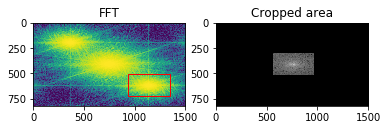

(2037884.6661783587+1229187.8345839647j)
(820, 1500)


'pil_im = Image.fromarray(np.uint8(centeredfft))\nplt.imshow(np.asarray(pil_im))'

In [92]:
class VideoReconstructor(VideoReconstructor):
    def imgshapeiden(self, X, filterScaleFact):
        
        sigma=5
        small_const = 30#25
        large_const = 2.5 #2.5

        iy=1;  # number of objects
        inc=0; # thresholding increasement

        if len(X.shape) is not 2:
            raise Exception('Wrong frame shape, must be monochrome')

        size_x, size_y = X.shape
        ccdImfft = np.fft.fftshift(np.fft.fft2(X))

        # print(ccdImfft)

        fftMagIm = np.log(np.abs(ccdImfft)+1);
        fftMagIm = (fftMagIm - np.min(np.min(fftMagIm)))/(np.max(np.max(fftMagIm))-np.min(np.min(fftMagIm))); #Convert to range [0,1]

        # print("Gaus Test:")

        sigma = 2 #int(max(sigma * min(size_x/100, size_y/100),1))

        gauss = gauss2D((sigma*3+1,sigma*3+1),sigma)
        I_eq = np.flip(np.flip(sp.ndimage.correlate(fftMagIm, gauss, mode='constant'),0),1) # Source: https://stackoverflow.com/questions/22142369/the-equivalent-function-of-matlab-imfilter-in-python?rq=1
        I_eq = equalize_hist(I_eq)
        #pil_im = Image.fromarray(np.uint8(fftMagIm))
        #I_eq = np.array(pil_im.filter(ImageFilter.GaussianBlur(sigma*3+1)))

        # print(I_eq.shape)
        # print(I_eq)

        small_img = round((size_x/small_const)*(size_y/small_const))
        big_img = round((size_x/large_const)*(size_y/large_const))

        print("Small Img")
        print(small_img)
        print("Big Img")
        print(big_img)

        level = threshold_otsu(I_eq)
        #level = 

        stp = level/100

        while iy is not 3:
            bw = I_eq >= level+inc    
            labelled = label(bw)
            bw4 = remove_small_objects(labelled, small_img, connectivity=8).astype(int)

            s_h = str(level+inc)

            #imsave(f'{folder_path}fft_{s_h}.tif',I_eq)
            #imsave(f'{folder_path}blob_{s_h}.tif',bw4)

            s = regionprops(bw4)
            iy = len(s)

            # We break if there are more than 3 images and none of them are bigger than big_img
            if iy == 3:
                area = [s[0].area, s[1].area, s[2].area]
                if max(area) > big_img:
                    iy = 1

            inc = inc+stp

            if inc >= 1-level:
                print("Failed to find threshold")
                
                fig,ax = plt.subplots(1,2)
                ax[0].imshow(I_eq)
                #edges2 = canny(I5, sigma=5)
                ax[1].imshow(bw4, cmap=plt.cm.gray)
                plt.show()
                
                centeredfft=None
                fftMagIm=None
                I3=None
                I5=None
                boundary=None
                return centeredfft,fftMagIm,I3,I5,boundary

        #print("Inc: ")    
        #print(inc)
        #print(level)

        #print(bw4)
        poz = []

        po1=s[0].centroid
        poz.append(abs(po1[0])+abs(po1[1]))
        #cen1=abs(abs(po1[0])-abs(po1[1]))
        po2=s[1].centroid
        poz.append(abs(po2[0])+abs(po2[1]))
        po3=s[2].centroid
        poz.append(abs(po3[0])+abs(po3[1]))

        which = poz.index(max(poz))

        boundingBox = list(s[which].bbox)
        boundingBox[2] = boundingBox[2]-boundingBox[0]
        boundingBox[3] = boundingBox[3]-boundingBox[1]
        #boundary = B{which}
        po=s[which].centroid

        halfx=abs(boundingBox[0]-po[0]) #Distance from centroid to start of bounding box
        halfy=abs(boundingBox[1]-po[1])
        halfacux=boundingBox[2]/2       
        halfacuy=boundingBox[3]/2

        if halfx>halfacux:
            boundingBox[2]= math.floor(halfx*2)
            boundingBox[2]= min(math.floor(halfx*2), ccdImfft.shape[0]-boundingBox[0])
        else:
            boundingBox[0]= math.floor(po[0]-halfx)
            boundingBox[0]= max(math.floor(po[0]-halfx), 0)

        if halfy>halfacuy:
            boundingBox[3]= math.floor(halfy*2) 
            boundingBox[3]= min(math.floor(halfy*2), ccdImfft.shape[1]-boundingBox[1])
        else:
            boundingBox[1]= math.floor(po[1]-halfy) 
            boundingBox[1]= max(math.floor(po[1]-halfy), 0)

        #boundingBox = [boundingBox[0],boundingBox[1],fftMagIm.shape[0]-boundingBox[0],fftMagIm.shape[1]-boundingBox[1]]

        mask = np.zeros((size_x,size_y))

        mask[boundingBox[0]:boundingBox[0]+boundingBox[2],
                boundingBox[1]:boundingBox[1]+boundingBox[3]] = 1

        #I3 = np.dot(fftMagIm.transpose(),mask)
        #ccdImfft=np.dot(ccdImfft.transpose(),mask)

        #print(np.sum(ccdImfft))

        I3 = fftMagIm*mask
        ccdImfft=ccdImfft*mask
        centeredfft = np.zeros((size_x,size_y),dtype=complex)

        '''pil_im = Image.fromarray(np.uint8(mask))
        plt.imshow(np.asarray(pil_im))'''     
        #print(np.sum(ccdImfft))

        i,j = np.where(ccdImfft == np.max(ccdImfft))
        #print(i)
        #print(j)

        bb2 = boundingBox.copy()

        bb2[0] = max(0,int(round(size_x/2 - abs(po[0]-bb2[0])))) # Changed from y to x
        bb2[1] = max(0,int(round(size_y/2 - abs(po[1]-bb2[1])))) # Changed from x to y

        # bb2 = [301,123,52,77]

        Window = ccdImfft[boundingBox[0]:boundingBox[0]+boundingBox[2],
            boundingBox[1]:boundingBox[1]+boundingBox[3]]

        cfft_shape = centeredfft[bb2[0]:bb2[0]+bb2[2],bb2[1]:bb2[1]+bb2[3]].shape

        print(po)
        print(ccdImfft.shape)
        print(centeredfft.shape)
        print(boundingBox)
        print("bb2")
        print(bb2)

        centeredfft[bb2[0]:bb2[0]+bb2[2],bb2[1]:bb2[1]+bb2[3]] = Window
        # figure, imshow(I4)
        Window1 = I3[boundingBox[0]:boundingBox[0]+boundingBox[2], 
                     boundingBox[1]:boundingBox[1]+boundingBox[3]]
        I5=np.zeros((size_x,size_y))

        I5[bb2[0]:bb2[0]+bb2[2], bb2[1]:bb2[1]+bb2[3]] = Window1

        '''print(boundingBox)
        print(bb2)
        print(np.max(ccdImfft))
        print(Window)


        print(type(centeredfft))
        print(type(Window))'''

        #blobs_log = blob_log(I_eq, min_sigma=30, max_sigma=500, num_sigma=10, threshold=.1)
        # Compute radii in the 3rd column.
        #blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)

        pil_im = Image.fromarray(np.float64(equalize_hist(I_eq)))
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(np.asarray(pil_im))
        ax[0].set_title('FFT')
        rect = patches.Rectangle((boundingBox[1],boundingBox[0]),boundingBox[3],boundingBox[2],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)

        #edges2 = canny(I5, sigma=5)
        ax[1].set_title('Cropped area')
        ax[1].imshow(I5, cmap=plt.cm.gray)

        '''for blob in blobs_log:
            y, x, r = blob
            c = plt.Circle((x, y), r, color='b', linewidth=2, fill=False)
            ax.add_patch(c)'''

        # approximate / simplify coordinates of the two ellipses
        for contour in find_contours(I_eq, 0):
            coords = approximate_polygon(contour, tolerance=2.5)
            ax[0].add_patch(coords[:, 1], coords[:, 0], '-r', linewidth=2)
            coords2 = approximate_polygon(contour, tolerance=39.5)
            ax[0].add_patch(coords2[:, 1], coords2[:, 0], '-g', linewidth=2)
            print("Number of coordinates:", len(contour), len(coords), len(coords2))

        plt.show()

        # Turns I_eq instead of None
        return centeredfft,fftMagIm,I3,I5,I_eq 
        #im = Image.fromarray(np.uint8(fftMagIm))
        #I_eq = im.filter(fspecial('gaussian',[sigma*3+1 sigma*3+1],sigma))

global_VR = VideoReconstructor()
        
centeredfft, fftMagIm, I3, I5, o = global_VR.imgshapeiden(gray,0.51)

print(np.sum(centeredfft)) 
print(centeredfft.shape)


'''pil_im = Image.fromarray(np.uint8(centeredfft))
plt.imshow(np.asarray(pil_im))'''   

In [93]:
class VideoReconstructor(VideoReconstructor):
    def fit_func(self, data,a,b,c,d,e,f):
        l_x = len(data[:,0])
        l_y = len(data[0])

        y = data[0]
        x = np.repeat(range(1,l_x+1), l_y)
        y = np.tile(range(1,len(data[0])+1), ((l_x,1))).flatten()

        '''print("X: ")
        print(x)
        print(x.shape)
        print("Y: ")
        print(y)
        print(y.shape)'''

        f = a+b*x+c*y+d*x*y+e*np.power(x,2)+f*np.power(y,2)
        return f

    def curve_params(self, pp):
        x,y = pp.shape
        lin_x = np.linspace(1,x,x)
        lin_y = np.linspace(1,y,y)
        tile_x = np.tile(lin_y,(x,1))
        tile_y = np.tile(lin_x.transpose(),(y,1)).transpose()

        xy = np.tile(lin_x.flatten(),(y,1))
        z = pp.transpose().flatten()

        popt, pcov = curve_fit(self.fit_func,xy,z) # , bounds=([0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

        print("Curve Parameters: " + str(popt))

        '''print(tile_x)
        print(tile_y)

        print(tile_x.shape)
        print(tile_y.shape)
        print((tile_x*tile_y).shape)
        print(np.power(tile_y,2).shape)

        print("Popt")
        print(popt)
        print(pcov)

        print("PP shape")
        print(pp.shape)

        print("Z: ")
        print(z)'''

        return popt

    def curve_removal(self, pp, params=None):
        x,y = pp.shape
        lin_x = np.linspace(1,x,x)
        lin_y = np.linspace(1,y,y)
        tile_x = np.tile(lin_y,(x,1))
        tile_y = np.tile(lin_x.transpose(),(y,1)).transpose()

        if params is not None:
            popt = params
        else:
            popt = self.curve_params(pp)

        return popt[0]+ popt[1]*tile_x+popt[2]*tile_y+popt[3]*tile_x*tile_y+popt[4]*np.power(tile_x,2)+popt[5]*np.power(tile_y,2)

Small Img
1367
Big Img
196800
(616.5707500248682, 1128.598751616433)
(820, 1500)
(820, 1500)
[508, 933, 217, 410]
bb2
[301, 554, 217, 410]


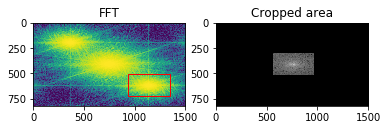

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Removing Curve
No previous curve parameters
Curve Parameters: [-2.56428839e+01 -7.93988213e-03 -2.03055415e-02 -2.69779252e-06
  2.08211686e-05  4.28345917e-05]
Curve Parameters: [-2.56428839e+01 -7.93988213e-03 -2.03055415e-02 -2.69779252e-06
  2.08211686e-05  4.28345917e-05]


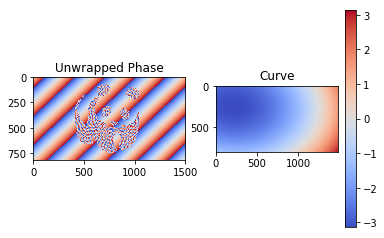

(array([[-11.14265412, -11.12272098, -11.0934187 , ..., -13.57505873,
         -13.59966755, -13.63194293],
        [-11.09282423, -11.07284571, -11.0434962 , ..., -13.52124343,
         -13.54581363, -13.5780425 ],
        [-11.04814127, -11.02813336, -10.99877044, ..., -13.47260688,
         -13.49718195, -13.52938518],
        ...,
        [ -4.20946424,  -4.18744391,  -4.15599953, ...,  -3.46005927,
          -3.48255928,  -3.5126276 ],
        [ -4.23833476,  -4.21623915,  -4.18475418, ...,  -3.48494145,
          -3.50738299,  -3.53741546],
        [ -4.26200677,  -4.23982667,  -4.20832284, ...,  -3.50460581,
          -3.52701539,  -3.55705884]]),
 array([[2.0026652 , 2.00937584, 2.0091263 , ..., 2.00296133, 2.00918748,
         2.00929917],
        [2.0093253 , 2.01608966, 2.01587138, ..., 2.00955668, 2.01589528,
         2.01610801],
        [2.01131845, 2.01823369, 2.01806909, ..., 2.01152099, 2.0180319 ,
         2.01833106],
        ...,
        [2.00767084, 2.01453279, 2.0

In [94]:
class VideoReconstructor(VideoReconstructor):
    c_params = None
    def ip_single_hologram(self, frame,curve):
        cut = 10
        filterScaleFact = 0.51

        if len(frame.shape) is not 2:
            raise Exception('Wrong frame shape, must be monochrome')
        size_x, size_y = frame.shape

        centeredfft_sample, I2, I3, I4, boundary = self.imgshapeiden(frame,filterScaleFact)

        if centeredfft_sample is None:
            return None,None,None

        #Show image:

        #ifft
        centeredImage_s = np.fft.ifft2(np.fft.fftshift(centeredfft_sample))
        f = np.angle(centeredImage_s)
        intensity=np.abs(centeredImage_s)
        pp = unwrap_phase(f)
        pp = pp[cut-1:size_x-cut,cut-1:size_y-cut]
        
        imsave(f'I:\\Honours-Project\\data\\test data\\2017.4.13qc\\wrapped.tif',f)

        '''print(pp)

        pil_im = Image.fromarray(np.uint8(pp))
        plt.imshow(np.asarray(pil_im))'''

        if np.sum(curve) == 0:
            print("Removing Curve")
            if self.c_params is None:
                print("No previous curve parameters")
                self.c_params = self.curve_params(pp)
            #curve=self.curve_removal(pp, self.c_params)
            curve = self.curve_removal(pp,None)

        #curve = pd.read_csv(curve_path, header=None).as_matrix()
        #pp = pd.read_csv(pp_path, header=None).as_matrix()

        intensity=intensity[cut-1:size_x-cut,cut-1:size_y-cut]
        phase=pp-curve
        
        fig,ax = plt.subplots(1,2)
        cax = ax[0].imshow(f,cmap=plt.cm.coolwarm)
        ax[0].set_title("Unwrapped Phase")
        
        # Add colorbar, make sure to specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        
        ax[1].set_title("Curve")
        ax[1].imshow(curve, cmap=plt.cm.coolwarm)
        plt.show()


        '''print("Centered Image:")
        print(centeredImage_s)
        print("Centered fft Sample: ")
        print(np.sum(centeredfft_sample))
        print(curve)
        print(pp)
        print(np.sum(phase))'''

        return phase,intensity,curve
    
global_VR = VideoReconstructor()
global_VR.ip_single_hologram(gray,0)

Small Img
1367
Big Img
196800
(616.5707500248682, 1128.598751616433)
(820, 1500)
(820, 1500)
[508, 933, 217, 410]
bb2
[301, 554, 217, 410]


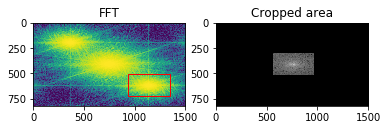

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Removing Curve
No previous curve parameters
Curve Parameters: [-2.56428839e+01 -7.93988213e-03 -2.03055415e-02 -2.69779252e-06
  2.08211686e-05  4.28345917e-05]
Curve Parameters: [-2.56428839e+01 -7.93988213e-03 -2.03055415e-02 -2.69779252e-06
  2.08211686e-05  4.28345917e-05]


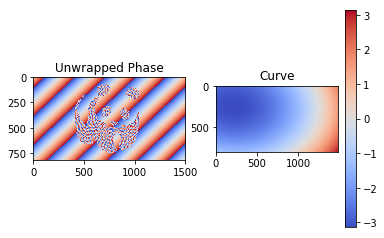

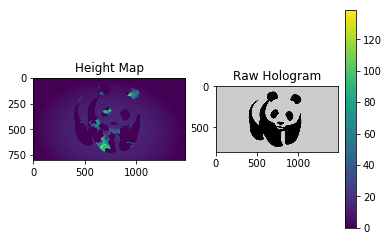

In [96]:
class VideoReconstructor(VideoReconstructor):
    dx=0.424
    dy=0.424
    dz=1.503

    def convert_to_heightmap_from_path(self,path,crop_walls=True):
        img = cv2.imread(path)
        return self.convert_to_heightmap(img,crop_walls)

    def convert_to_heightmap(self,img,crop_walls):
        
        if len(img.shape) > 2:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        
        '''if self.c_params is None:
            cropped = self.crop_walls(gray)
            self.convert_to_heightmap(cropped)'''
        
        if crop_walls:
            if self.c_params is None:
                gray = self.crop_walls(gray)
            else:
                gray = self.crop_border(gray)
        
        phase, intensity, curve = self.ip_single_hologram(gray,0)
        height = phase*self.dz

        #print(height)

        gauss = gauss2D((3*3+1,3*3+1),3)
        height_s = sp.ndimage.correlate(height, gauss, mode='constant') # Source: https://stackoverflow.com/questions/22142369/the-equivalent-function-of-matlab-imfilter-in-python?rq=1
        #height_s = np.flip(np.flip(sp.ndimage.correlate(height, gauss, mode='constant'),0),1)

        #print("Height S: ")
        #print(height_s)

        img_x, img_y = phase.shape

        height_r = height_s.copy()
        height_r[height_r < 0] = 0
        s_areatotal= img_x*img_y*self.dx*self.dy

        level = threshold_otsu(height_r)
        bw1 = height_r >= level

        #B = bwboundaries(bw1);

        smalls=round(math.sqrt(img_x*img_y)/40)
        bigs=round((img_x*img_y)/30)

        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(smalls,smalls))
        bw2 = binary_closing(bw1, se)

        labelled = label(bw2)
        bw3 = remove_small_objects(labelled, bigs, connectivity=8)

        s = regionprops(bw3)

        #B = bwboundaries(bw3);
        height_remove= height_s*bw3

        count = len(s)

        #if count != 0:
        #    for m in range(count):

        '''print(height_r)
        print(np.sum(phase))
        print(height_s.shape)
        print(bw3.shape)
        print(height_remove.shape)
        print(s_areatotal)
        print(level)'''

        fig,ax = plt.subplots(1,2)
        cax = ax[0].imshow(height_r)
        ax[0].set_title("Height Map")
        
        # Add colorbar, make sure to specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        
        
        ax[1].set_title("Raw Hologram")
        ax[1].imshow(intensity, cmap=plt.cm.gray)
        plt.show()

        return height_r

        '''pil_im.save('out.bmp')'''
global_VR = VideoReconstructor()
recon = global_VR.convert_to_heightmap(gray,crop_walls=False)
#global_VR.convert_to_heightmap_from_path(image_path,crop_walls=False)

In [98]:
cv2.imshow('image',recon)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Convert all video frames

In [ ]:
fp = f'{folder_path}//video//'
fp = f'I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\'

vr = VideoReconstructor()

for file in os.listdir(fp):
    if fnmatch.fnmatch(file, '*.tif'):
        converted = vr.convert_to_heightmap_from_path(f'{fp}{file}',False)
        imsave(f'{fp}\\converted\\{file}',converted)

In [ ]:
fp = f'{folder_path}//video'

for file in os.listdir(fp):
    if fnmatch.fnmatch(file, '*.tif'):
        img = cv2.imread(f'{fp}//{file}')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = crop_walls(gray)
        centeredfft,fftMagIm,I3,I5,I_eq = imgshapeiden(gray,0.51)
        imsave(f'{fp}//fft_v2_{file}',I_eq)

In [ ]:
height_path = "I:\\Honours-Project\\data\\height_r.csv"
img = pd.read_csv(height_path, header=None).as_matrix()

pil_im = Image.fromarray(np.uint8(img))
plt.imshow(np.asarray(pil_im))     

In [ ]:
def play_video(path, filename):
    cap = cv2.VideoCapture(path)

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    if(cap.isOpened()):
        frame_height = cap.get(CV_CAP_PROP_FRAME_HEIGHT)
        frame_width = cap.get(CV_CAP_PROP_FRAME_WIDTH)
        frame_count = cap.get(CV_CAP_PROP_FRAME_COUNT)
        fps = cap.get(CV_CAP_PROP_FPS)

        M = frame_height*frame_width

        print("Frame Count: " + str(frame_count))

    count = 0
    key_frames = []
    
    #vr = VideoReconstructor()

    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret == True:
            '''gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            gray = crop_walls(gray)
            
            centeredfft,fftMagIm,I3,I5,I_eq = imgshapeiden(gray,0.51)'''
            
            #img = vr.convert_to_heightmap(frame)
            
            '''converted = convert_to_heightmap(frame)
            
            if converted is None:
                print("Converted is None")
                continue
            
            c_height, c_width = converted.shape
            
            if frame_height != c_height or c_width != frame_width:
                print("Converted not same size as original")
                break
            
            print(type(converted))'''

            # Display the resulting frame
            cv2.imshow('Frame',img)

            # if(count % 14 == 0):
            if count >= 0: 
                imagePath='I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\{0}_frame{1}.tif'.format(filename, count)
                
                print("Saving image to " + imagePath)
                
                cv2.imwrite(imagePath,frame)
                key_frames.append(frame)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        # Break the loop
        else: 
            break

        count += 1

    # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

## Store frames from test images

In [ ]:
path = f'I:\\Honours-Project\\data\\test data\\2017.4.13qc'

for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.avi'):
        play_video(f'{path}\\{file}',file)

## Store Frames from Thrombus Images

In [ ]:
for path, date, flowrate in source_folders:
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, '*.avi'):
            print(file)
            play_video(f'{path}\\{file}',file)

In [ ]:
play_video('I:\\Honours-Project\\data\\test data\\2017.4.13qc\\MATLAB_0004.avi','MATLAB_0004.avi')

## Play video

In [ ]:
def get_last(elem):
    m = re.findall(r'(\d+)', elem)
    if m:
        found = m[-1]
    return int(m[0])*1000000+int(found)

get_last('Playing MATLAB_0001.avi_frame17.tif')

In [ ]:
img_path = f'I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\converted\\MATLAB_0002.avi_frame1.tif'

img = cv2.imread(img_path)
z = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x, y = np.meshgrid(range(z.shape[0]), range(z.shape[1]))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x,y,z,cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
path = f'I:\\Honours-Project\\data\\test data\\2017.4.13qc\\frames\\converted'

for count, file in enumerate(sorted(os.listdir(path),key=get_last), start=1):
    if fnmatch.fnmatch(file, '*.tif'):
        img = cv2.imread(f'{path}\\{file}')
        cv2.imshow('frame',img)
        
        print("Playing " + file)
        
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
            
cv2.destroyAllWindows()